### Let's do a regression example!
 
 Let's predict fuel efficiency

In [1]:
#The imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.layers.experimental import preprocessing

In [14]:
#Let's download the data!
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)


In [15]:
dataset = raw_dataset.copy()
dataset = dataset.dropna()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [16]:
#Let's convert origin to numeric value
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})


In [17]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


In [18]:
#let's split the data into training and testing!
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

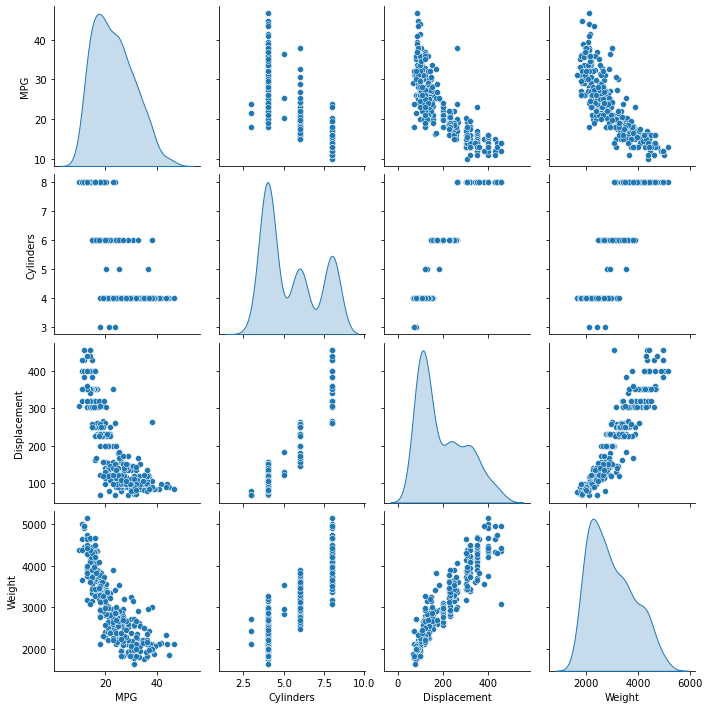

In [19]:
#Let's look at the data
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [20]:
#Let's split the features (x) from the labels (y)
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [21]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[5.47770691e+00 1.95318497e+02 1.04869446e+02 2.99025171e+03
 1.55592356e+01 7.58980942e+01 1.78343967e-01 1.97452217e-01
 6.24203861e-01]


In [22]:
## Let's do a linear model first!
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])
linear_model.predict(train_features[:10])

array([[ 0.12738246],
       [-1.5999365 ],
       [-0.27892512],
       [-1.1352844 ],
       [ 0.14712691],
       [-1.2808571 ],
       [ 0.08012551],
       [-0.19780618],
       [-0.51762235],
       [ 0.8548701 ]], dtype=float32)

In [23]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


In [24]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Wall time: 3.86 s


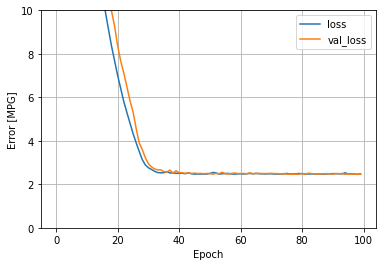

In [25]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
plot_loss(history)

In [28]:
test_results = {}
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)
print(test_results['linear_model'])

2.4989702701568604


In [33]:
# Let's now try a DNN
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_4 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [34]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 4.97 s


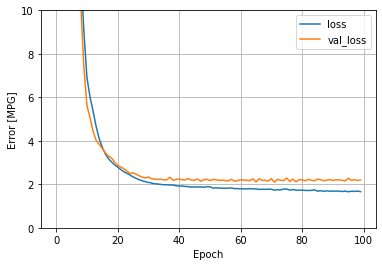

In [35]:
plot_loss(history)

In [36]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)


In [37]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linear_model,2.49897
dnn_model,1.70925


### Let's do a classification example!
 
 Let's classify images of clothing!

In [38]:
#Import the dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [39]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
train_images.shape

(60000, 28, 28)

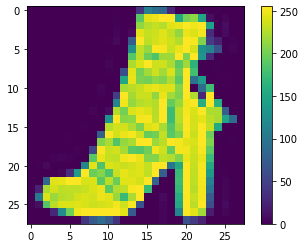

In [41]:
#Let's plot a random image
plt.figure()
plt.imshow(train_images[11])
plt.colorbar()
plt.grid(False)
plt.show()


In [43]:
# Let's normalize our data
train_images = train_images / 255.0

test_images = test_images / 255.0

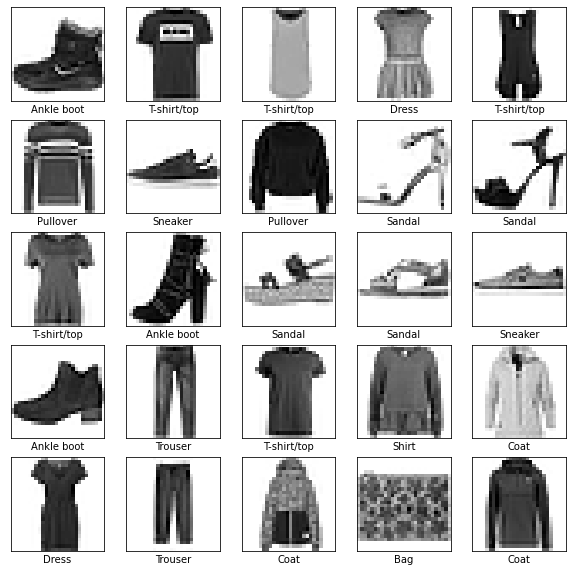

In [44]:
#Let's look at the data
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [45]:
#Now let's build the model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])


In [46]:
#Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [47]:
#train
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5013 - accuracy: 0.8230
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3772 - accuracy: 0.8631
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3354 - accuracy: 0.8773: 0s - loss: 0.3365 - 
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3100 - accuracy: 0.8865
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2907 - accuracy: 0.8921
Epoch 6/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2789 - accuracy: 0.8972
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2639 - accuracy: 0.9022
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2535 - accuracy: 0.9078
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2453 - accuracy: 0.9080: 0s - loss: 0
Epoch 10/10
1875/1875 [=======================

In [49]:
#Let's test its accuracy!
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)


313/313 - 0s - loss: 0.3493 - accuracy: 0.8820

Test accuracy: 0.8820000290870667


In [50]:
#make predictions
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])


In [51]:
predictions = probability_model.predict(test_images)

In [52]:
predictions[0]

array([1.2531829e-06, 4.4376871e-09, 3.7106046e-10, 2.3632601e-10,
       8.4563707e-09, 5.7861168e-04, 9.1907932e-06, 2.4641069e-02,
       3.8671605e-08, 9.7476983e-01], dtype=float32)

In [53]:
np.argmax(predictions[0])

9

In [45]:
test_labels[0]

9

In [54]:
#ax functions
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


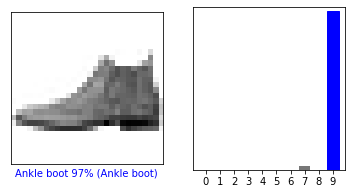

In [55]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

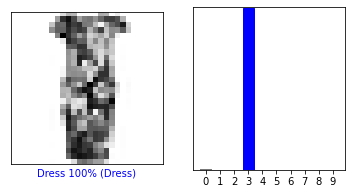

In [61]:
i = 100
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

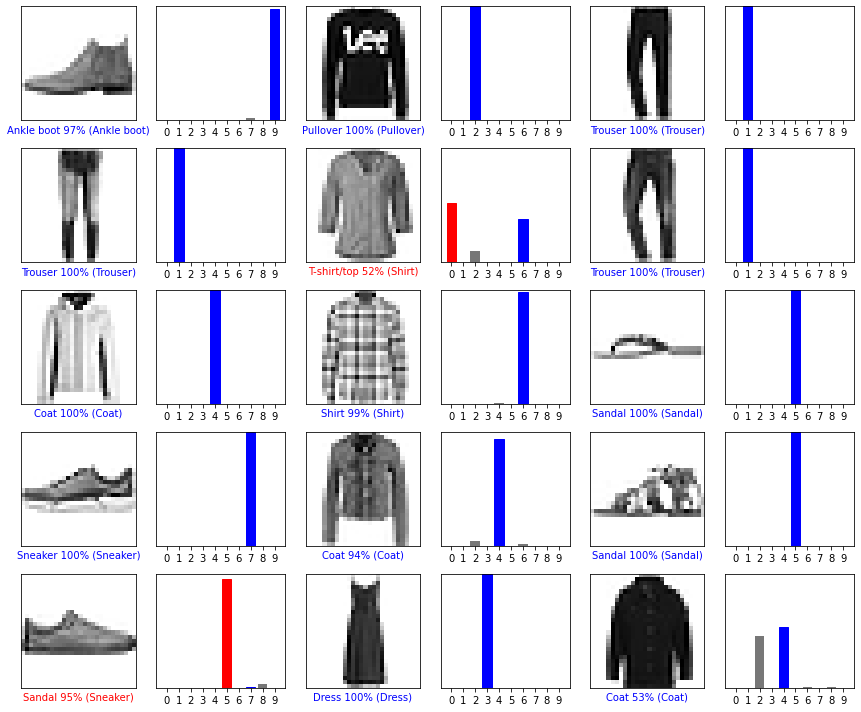

In [62]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Now let's navigate some of the options that we used!

### Layers
We used Dense above, which is just your regular densely-connected NN layer.

    ''' 
    tf.keras.layers.Dense(
    units, activation=None, use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros', kernel_regularizer=None,
    bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
    bias_constraint=None, **kwargs
    )
    '''


In [63]:
# Create a `Sequential` model and add a Dense layer as the first layer.
modell = tf.keras.models.Sequential()
modell.add(tf.keras.Input(shape=(16,)))
modell.add(tf.keras.layers.Dense(32, activation='relu'))
# Now the model will take as input arrays of shape (None, 16)
# and output arrays of shape (None, 32).
# Note that after the first layer, you don't need to specify
# the size of the input anymore:
modell.add(tf.keras.layers.Dense(32))
modell.output_shape


(None, 32)

In [64]:
modell.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________


More than 30 types of layers in tensorflow, check them here! https://www.tensorflow.org/api_docs/python/tf/keras/layers

### activation functions

In [66]:
#Relu
foo = tf.constant([-10, -5, 0.0, 5, 10], dtype = tf.float32)
m=tf.keras.activations.relu(foo,alpha=0.0, max_value=4, threshold=0).numpy()
print(m)

[0. 0. 0. 4. 4.]


In [67]:
#elu
# x if x > 0 
# if x<0 alpha * (exp(x) - 1) 
foo = tf.constant([-10, -5, 0.0, 5, 10], dtype = tf.float32)
m=tf.keras.activations.elu(foo,alpha=10).numpy()
print(m)

[-9.999546 -9.932621  0.        5.       10.      ]


In [69]:
#tanh
# tanh(x) = sinh(x)/cosh(x) = ((exp(x) - exp(-x))/(exp(x) + exp(-x))).
foo = tf.constant([-1000, -5, 0.0, 5, 1000], dtype = tf.float32)
m=tf.keras.activations.tanh(foo).numpy()
print(m)

[-1.         -0.99990916  0.          0.99990916  1.        ]


In [70]:
#Sigmoid
# sigmoid(x) = 1 / (1 + exp(-x))
foo = tf.constant([-10000, -5, 0.0, 5, 10000], dtype = tf.float32)
m=tf.keras.activations.sigmoid(foo).numpy()
print(m)

[0.         0.00669286 0.5        0.9933071  1.        ]


For more on activation functions: https://www.tensorflow.org/api_docs/python/tf/keras/activations

### Optimizers 
Let's now go over some 

In [71]:
#Keras basic optimizer
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#train
model.fit(train_images, train_labels, epochs=2)

Epoch 1/2
1875/1875 [==============================] - ETA: 0s - loss: 0.1991 - accuracy: 0.92 - 8s 4ms/step - loss: 0.1991 - accuracy: 0.9261
Epoch 2/2
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1924 - accuracy: 0.9280


In [72]:
#RMSprop
model.compile(optimizer='RMSprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#train
model.fit(train_images, train_labels, epochs=2)

Epoch 1/2
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2307 - accuracy: 0.9159
Epoch 2/2
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2292 - accuracy: 0.9171


In [73]:
#Adam
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#train
model.fit(train_images, train_labels, epochs=2)

Epoch 1/2
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2238 - accuracy: 0.9171
Epoch 2/2
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2144 - accuracy: 0.9202


#### Learning rate scheduler

In [74]:
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1,
    decay_rate=0.9,
    staircase=True)

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=3)


Epoch 1/3
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1863 - accuracy: 0.9296
Epoch 2/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1860 - accuracy: 0.9297: 0s - loss:
Epoch 3/3
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1860 - accuracy: 0.9297


For more on optimizers: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

### Loss functions 
Loss functions for regression are different from that for classification

These functions greatly impact the model. Some are harder to optimiz but has a physical meaning to the problem!

Some functions on tensorflow:
class BinaryCrossentropy: Computes the cross-entropy loss between true labels and predicted labels.

<code> class CategoricalCrossentropy </code>: Computes the crossentropy loss between the labels and predictions.

<code>class CategoricalHinge</code>: Computes the categorical hinge loss between y_true and y_pred.

<code>class CosineSimilarity</code>: Computes the cosine similarity between labels and predictions.

<code>class Hinge</code>: Computes the hinge loss between y_true and y_pred.

<code>class KLDivergence</code>: Computes Kullback-Leibler divergence loss between y_true and y_pred.


<code>class MeanAbsoluteError</code>: Computes the mean of absolute difference between labels and predictions.

<code>class MeanAbsolutePercentageError</code>: Computes the mean absolute percentage error between y_true and y_pred.

<code>class MeanSquaredError</code>: Computes the mean of squares of errors between labels and predictions.

<code>class MeanSquaredLogarithmicError</code>: Computes the mean squared logarithmic error between y_true and y_pred.


<code>class SparseCategoricalCrossentropy</code>: Computes the crossentropy loss between the labels and predictions.

<code>class SquaredHinge</code>: Computes the squared hinge loss between y_true and y_pred.

In [76]:
#SparseCategoricalCrossentropy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#train
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3148 - accuracy: 0.9018
Epoch 2/3
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2201 - accuracy: 0.9184: 0s -
Epoch 3/3
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2089 - accuracy: 0.9219


In [77]:
#SparseCategoricalCrossentropy
model.compile(optimizer='adam',
              loss=tf.keras.losses.Hinge(),
              metrics=['accuracy'])
#train
model.fit(train_images, train_labels, epochs=2)

Epoch 1/2
1875/1875 [==============================] - 8s 4ms/step - loss: 1.1539 - accuracy: 0.1326 - ETA: 0s -
Epoch 2/2
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1207 - accuracy: 0.0963


In [78]:
#BinaryCrossentropy (not applicable)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
#train
model.fit(train_images, train_labels, epochs=2)

Epoch 1/2
1875/1875 [==============================] - 7s 4ms/step - loss: -53.4110 - accuracy: 0.1005
Epoch 2/2
1875/1875 [==============================] - 8s 4ms/step - loss: -53.5649 - accuracy: 0.1009


For more on loss functions: https://www.tensorflow.org/api_docs/python/tf/keras/losses

### Metrics 
Metrics do not impact the performance of the model or the optimization process. They are there to help you evaluate the performance of the model, but they are different from regression to calssification. 

https://www.tensorflow.org/api_docs/python/tf/keras/metrics

for example 
<code> class CategoricalHinge </code>: Computes the categorical hinge metric between y_true and y_pred.

In [80]:
#Hinge(not applicable)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['CategoricalHinge'])
#train
model.fit(train_images, train_labels, epochs=1)

1875/1875 [==============================] - 10s 5ms/step - loss: 2.3012 - categorical_hinge: 1457.9290 1s - loss: 2.3 - ETA: 0s - loss:


In [81]:
#(not useful)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['MeanSquaredError'])
#train
model.fit(train_images, train_labels, epochs=1)

1875/1875 [==============================] - 10s 5ms/step - loss: 2.2986 - mean_squared_error: 1789.8444: 2s - l


In [82]:
#(not applicable)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['Precision'])
#train
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3


ValueError: in user code:

    C:\Users\PEESE\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Users\PEESE\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\PEESE\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\PEESE\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\PEESE\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\PEESE\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\Users\PEESE\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:800 train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    C:\Users\PEESE\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:460 update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    C:\Users\PEESE\Anaconda3\lib\site-packages\tensorflow\python\keras\utils\metrics_utils.py:86 decorated
        update_op = update_state_fn(*args, **kwargs)
    C:\Users\PEESE\Anaconda3\lib\site-packages\tensorflow\python\keras\metrics.py:177 update_state_fn
        return ag_update_state(*args, **kwargs)
    C:\Users\PEESE\Anaconda3\lib\site-packages\tensorflow\python\keras\metrics.py:1327 update_state  **
        return metrics_utils.update_confusion_matrix_variables(
    C:\Users\PEESE\Anaconda3\lib\site-packages\tensorflow\python\keras\utils\metrics_utils.py:366 update_confusion_matrix_variables
        y_pred.shape.assert_is_compatible_with(y_true.shape)
    C:\Users\PEESE\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (32, 10) and (32, 1) are incompatible


Refernces:
    - François Chollet
    - Tensorflow.org
